# Pré-processamento dos dados textuais

## Transformando os dados em um dataset

In [1]:
!pip -q install pandas
!pip -q install unidecode
!pip -q install nltk
!pip -q install sklearn

In [2]:
import pandas as pd
df_base = pd.read_json('goodreads_books.json')
n_samples = 4000
df_mini = df_base.sample(n=n_samples, random_state=1)
df_mini.head()

,book_id,description,genre,language_code
51285,27833724,Tang Tu niGao Bai shiteshimatsutaShan Tian . s...,comics_graphic,eng
615323,24754076,Sixteen year-old Madeline has struggled with e...,young_adult,eng
118404,8737174,The epic story of Thomas Cale-introduced so me...,fantasy_paranormal,eng
574805,15831501,Having a father who thought business came firs...,romance,eng
369607,892602,Last night I dreamt I went to Manderley again ...,mystery_thriller_crime,eng


## Limpeza dos dados

In [3]:
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/igor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]

def text_clean(df_text_column, log=False):
    if log: print("Starting")

    # Dividindo texto em tokens
    df_text_column = df_text_column.apply(word_tokenize)

    if log: print("Tokens split done")  # Some log

    # Convertendo texto para minusculo
    df_text_column = df_text_column.apply(array_lower)

    if log: print("Upper letters converted to normal")

    # Removendo pontuação
    df_text_column = df_text_column.apply(remove_punctuation)

    if log: print("Removed punctiation")

    # Removendo caracteres especiais
    df_text_column = df_text_column.apply(remove_specials)

    if log: print("Specials chars removed")

    # Removendo tokens que não sao palavras
    df_text_column = df_text_column.apply(remove_no_words)

    if log: print("Removed non-words tokens")

    # Removendo tokens que são stop words
    df_text_column = df_text_column.apply(remove_stop_words)

    if log: print("Removed tokens that are stop-words\nFinished")

    return df_text_column


In [6]:
# Auxiliar log function
def size_df(d):
    print("Size=", d.memory_usage(deep=True).sum()/10**9, "GB")

In [7]:
df_mini['description'] = text_clean(df_mini['description'])
df_mini.head()

,book_id,description,genre,language_code
51285,27833724,"[tang, tu, nigao, bai, shiteshimatsutashan, ti...",comics_graphic,eng
615323,24754076,"[sixteen, yearold, madeline, struggled, epilep...",young_adult,eng
118404,8737174,"[epic, story, thomas, caleintroduced, memorabl...",fantasy_paranormal,eng
574805,15831501,"[father, thought, business, came, first, daugh...",romance,eng
369607,892602,"[last, night, dreamt, went, manderley, novel, ...",mystery_thriller_crime,eng


In [8]:
# df_base.loc[51285, 'description'] # Noisy data

# Stemming

In [9]:
from nltk.stem.porter import PorterStemmer

In [10]:
porter = PorterStemmer()
stemmized = lambda d: [porter.stem(tk) for tk in d]
df_mini['description'] = df_mini['description'].apply(stemmized)
df_mini.head()

,book_id,description,genre,language_code
51285,27833724,"[tang, tu, nigao, bai, shiteshimatsutashan, ti...",comics_graphic,eng
615323,24754076,"[sixteen, yearold, madelin, struggl, epilepsi,...",young_adult,eng
118404,8737174,"[epic, stori, thoma, caleintroduc, memor, left...",fantasy_paranormal,eng
574805,15831501,"[father, thought, busi, came, first, daughter,...",romance,eng
369607,892602,"[last, night, dreamt, went, manderley, novel, ...",mystery_thriller_crime,eng


# TFIDF


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Using the hand made preprocessor

In [12]:
do_nothing = lambda x: x
vect_manual = TfidfVectorizer(tokenizer=do_nothing, lowercase=False, preprocessor=do_nothing, ngram_range=(1, 1))
freq = vect_manual.fit_transform(df_mini['description'].values.tolist())
df_freq = pd.DataFrame(data=freq.todense(), columns=vect_manual.get_feature_names_out())
df_freq.head()

,aaaa,aaaaaaaaaacachew,aamer,aangesproken,aar,aaron,aazuria,ab,abaddon,abandon,...,zurich,zusammen,zuvich,zuydocoot,zwar,zwei,zwischen,zygar,zygard,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using only the class from sklearn

In [13]:
# vect = TfidfVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1, 1))
# freq = vect.fit_transform(df_mini['description'].values.tolist())
# df_freq = pd.DataFrame(data=freq.todense(), columns=vect.get_feature_names_out())
# df_freq.head()

# PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_samples)

In [15]:
pca.fit(df_freq);

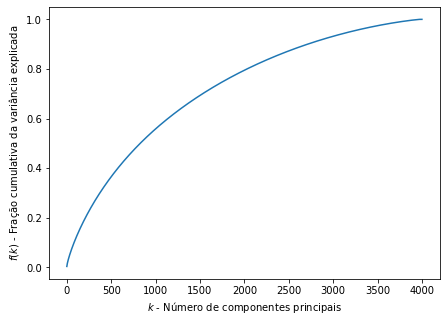

In [16]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(7, 5))
plt.plot([i for i in range(1, pca.n_components + 1)], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel(r'$k$ - Número de componentes principais')
plt.ylabel(r'$f(k)$ - Fração cumulativa da variância explicada');

Aplicando o número máximo de componentes principais percebemos que talvez seja preciso um aumento no número de samples uma vez que o valor de componentes principais deve estar no intervalo entre
$$ \[
    \left[1, \ min(n_{samples} \ , \ n_{features}) \right]
\] $$